In [1]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
import matplotlib.animation as anim
#from mpl_toolkits.mplot3d import Axes3D

Punto 1: 

In [2]:
class Particle():
    
    def __init__(self, x0, v0, a0, t, m, radio, Id):   
                                                        
        self.dt = t[1] - t[0] 
        self.r = x0     
        self.v = v0  
        self.a = a0  
        
        self.rVector = np.zeros( (len(t),len(x0)) )    
        self.vVector = np.zeros( (len(t),len(v0)) )
        self.aVector = np.zeros( (len(t),len(a0)) )
        
        self.m = m
        self.radio = radio
        self.Id = Id
        
    def Evolution(self,i):         
        
        self.setPosition(i,self.r)
        self.setVelocity(i,self.v)
        
        #Ecuaciones diferenciales según método de Euler
        
        self.r += self.dt*self.v     
        self.v += self.dt*self.a
    
    def CheckWallLimits(self, limits, dim=2):
        
        for i in range(dim):       #Se multiplica por 0.9 en cada condición para garantizar la pérdida de energía
            
            if self.r[i] + self.radio > limits[i]:
                
                self.v[i] = - 0.9*self.v[i]
            
            if self.r[i] - self.radio < - limits[i]:
                
                self.v[i] = - 0.9*self.v[i]
                
    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]]) # initial condition
        self.RvVector = np.array([self.vVector[0]])
        
        for i in range(1,len(self.rVector)):
            
            if i%factor == 0:
                
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])
                
    #Setters: Permite fijar los atributos, son métodos que no deberían retonar
    
    def setPosition(self, i, r):
        
        self.rVector[i] = r
        
    def setVelocity(self, i, v):
        self.vVector[i] = v
        
    #Getters: Ver los valores de los atributos, son métodos que normalmente retornan algo
    
    def GetR(self):
        
        return self.radio
    
    def GetPositionVector(self):
        
        return self.rVector
    
    def GetRPositionVector(self):
        
        return self.RrVector
        
    def GetRVelocityVector(self):
        
        return self.RvVector
    
    def GetVelocityVector(self):
        
        return self.vVector

In [31]:
#Discretización 

dt = 0.01
tmax = 30
t = np.arange(0, tmax + dt, dt) 

In [32]:
def GetParticles(NParticles, Limit, Velo, Dim = 2, dt = 0.1):      #Genera las partículas
    
    Particles_ = []
    
    for i in range(NParticles):
        
        #Asegura las condiciones iniciales
        
        x0 = np.array([-15.,5.])
        v0 = np.array([1.,0.]) 
        a0 = np.array([0.,-9.8])
        
        p = Particle(x0,v0,a0,t,1.,1.,i)      #Radio = 1, masa = 1
        
        Particles_.append(p)
        
    return Particles_     

In [33]:
limits = np.array([20.,20.])     #Caja ajustada a 20x20

def RunSimulation(t, Velo, NParticles):
    
    Particles = GetParticles(NParticles,limits[0],Velo,dt=dt)
    
    #Particles[0].GetPositionVector = np.array([-15.,5.])
    
    for it in tqdm(range(len(t))):  
        
        for i in range(len(Particles)):
            
            Particles[i].CheckWallLimits(limits)
            Particles[i].Evolution(it)
            
    return Particles

Simulación 

In [34]:
Particles = RunSimulation(t,NParticles=1,Velo=50)

100%|███████████████████████████████████████████████████████████████████████████| 3001/3001 [00:00<00:00, 35208.10it/s]


In [35]:
#Reducción del tiempo

def ReduceTime(t,factor):
    
    for p in Particles:
        
        p.ReduceSize(factor)
        
    Newt = []
    
    for i in range(len(t)):
        
        if i%factor == 0:
            
            Newt.append(t[i])
            
    return np.array(Newt)

In [36]:
redt = ReduceTime(t,10)      #Reducción en 10

<IPython.core.display.Javascript object>


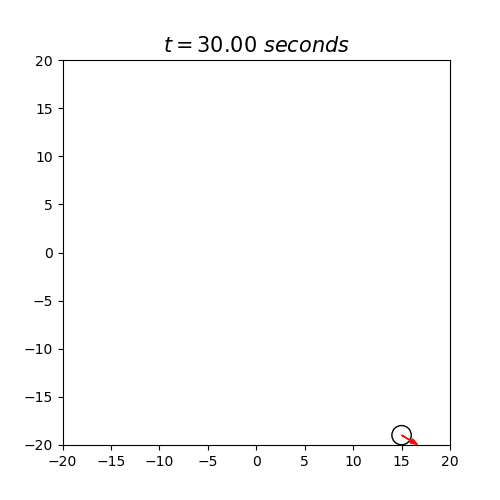

In [37]:
#Animaciones

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

#Función de inicio

def init():  
    
    ax.set_xlim(-limits[0],limits[0])
    ax.set_ylim(-limits[1],limits[1])
    
#Función de actualización

def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15) 
    
    for p in Particles:
        
        x = p.GetRPositionVector()[i,0]
        y = p.GetRPositionVector()[i,1]
        
        vx = p.GetRVelocityVector()[i,0]
        vy = p.GetRVelocityVector()[i,1]
        
        circle = plt.Circle((x,y), p.GetR(), color='k', fill = False)
        plot = ax.add_patch(circle)
        plot = ax.arrow(x, y, vx, vy, color='r', head_width=0.5)    
        
    return plot

Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)

Gráfica energía cinética

In [38]:
def KEnergy(p,t):
    
    v = p.GetVelocityVector()
    Energy = []
    
    for i in v: 
        
        e = 1/2 * 1 * np.sqrt(i[0]**2 + i[1]**2)
        
        Energy.append(e)
        
    fig = plt.figure()
    plt.xlabel('Time[s]')
    plt.ylabel('Kinetic Energy[J]')
    plt.plot(t,np.array(Energy))
    #plt.savefig('dt={:2f}.png'.format(dt))
    
    return fig

<IPython.core.display.Javascript object>


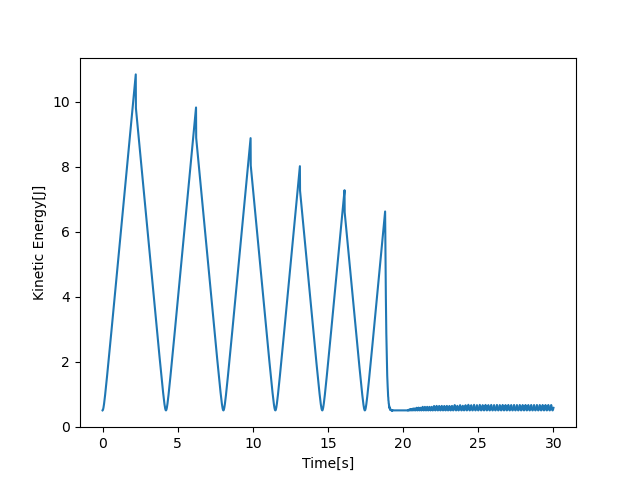

<IPython.core.display.Javascript object>


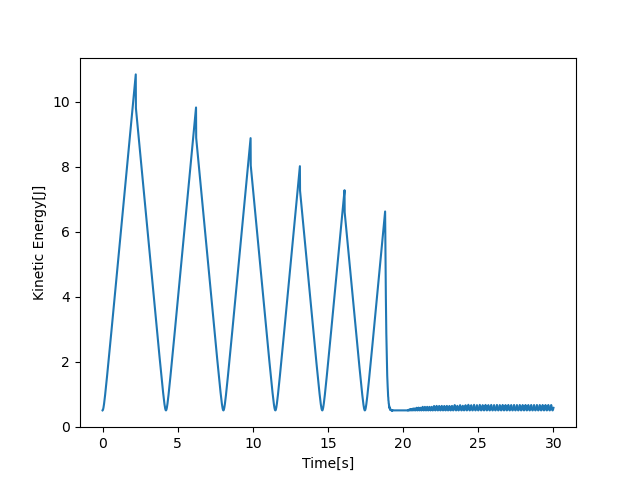

In [39]:
KEnergy(Particles[0],t)

Estimación tiempo para que la bola se detenga:

In [24]:
#Discretización 

dt = 0.001
tmax = 45
t = np.arange(0, tmax + dt, dt) 

In [25]:
def RunSimulation(t, Velo, NParticles):
    
    Particles = GetParticles(NParticles,limits[0],Velo,dt=dt)
    
    for it in tqdm(range(len(t))):  
        
        for i in range(len(Particles)):
            
            Particles[i].CheckWallLimits(limits)
            Particles[i].Evolution(it)
            
    return Particles

In [26]:
Particles = RunSimulation(t,NParticles=1,Velo=50)

100%|█████████████████████████████████████████████████████████████████████████| 45001/45001 [00:00<00:00, 46316.79it/s]


<IPython.core.display.Javascript object>


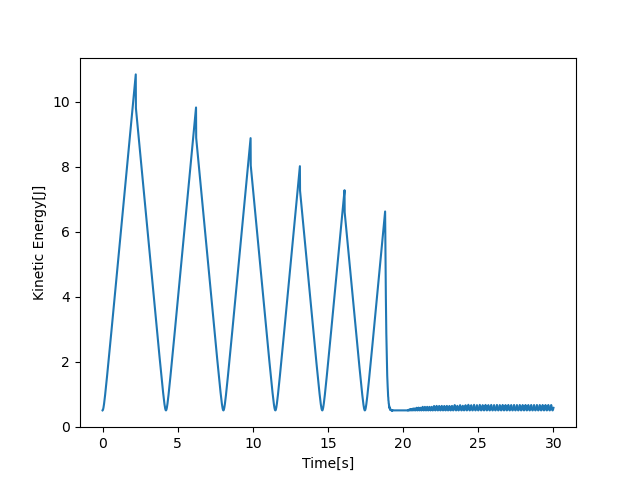

<IPython.core.display.Javascript object>


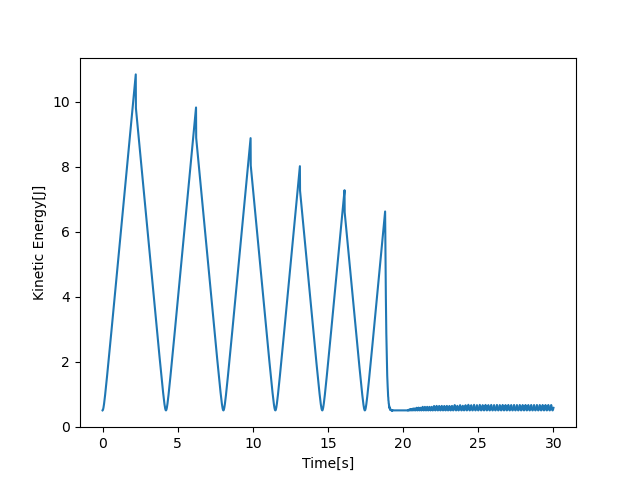

In [40]:
KEnergy(Particles[0],t)

Punto 2 -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
class Particle():
    
    def __init__(self, x0, v0, a0, t, m, radio, Id):   #Se trata del constructor de clase ''cómo construir el objeto''
                                                        #Siempre lleva el self porque hace referencia al objeto en creación
        self.dt = t[1] - t[0] #Paso del tiempo, es siempre constante
        self.r = x0     #Inicializar atributos
        self.v = v0  
        self.a = a0  
        
        self.rVector = np.zeros( (len(t),len(x0)) )    #Inicializar una matriz
        self.vVector = np.zeros( (len(t),len(v0)) )
        self.aVector = np.zeros( (len(t),len(a0)) )
        
        self.m = m
        self.radio = radio
        self.Id = Id
        
    def Evolution(self,i):         #Ya es un método de la clase, con el self toma todo lo relacionado con el objeto
        
        self.setPosition(i,self.r)
        self.setVelocity(i,self.v)
        
        #Ecuaciones diferenciales según método de Euler
        
        self.r += self.dt*self.v     
        self.v += self.dt*self.a
    
    def CheckWallLimits(self, limits, dim=3):
        
        for i in range(dim):
            
            if self.r[i] + self.radio > limits[i]:
                
                self.v[i] = - self.v[i]
            
            if self.r[i] - self.radio < - limits[i]:
                
                self.v[i] = - self.v[i]
                
    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]]) # initial condition
                
        for i in range(1,len(self.rVector)):
            
            if i%factor == 0:
                
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                
    #Setters: Permite fijar los atributos, son métodos que no deberían retonar
    
    def setPosition(self, i, r):
        
        self.rVector[i] = r
        
    def setVelocity(self, i, v):
        self.vVector[i] = v
        
    #Getters: Ver los valores de los atributos, son métodos que normalmente retornan algo
    
    def GetR(self):
        
        return self.radio
    
    def GetPositionVector(self):
        
        return self.rVector
    
    def GetRPositionVector(self):
        
        return self.RrVector
        
    def GetVelocityVector(self):
        
        return self.vVector

In [41]:
#Discretización

dt = 0.001
tmax = 5
t = np.arange(0, tmax + dt, dt) 

In [42]:
def GetParticles(NParticles, Limit, Velo, Dim = 3, dt = 0.1):      #Genera las partículas
    
    Particles_ = []
    
    for i in range(NParticles):
        
        x0 = np.random.uniform(-Limit+1.0, Limit-1.0, size=Dim) #genera posiciones aleatorias de la dimensión especificada
        v0 = np.random.uniform(-Velo, Velo, size=Dim) #x0 Tienen una tolerancia que en realidad debería ser el radio de la partícula
        a0 = np.zeros(Dim)
        
        p = Particle(x0,v0,a0,t,1.,.2,i)
        
        Particles_.append(p)
        
    return Particles_     

In [43]:
limits = np.array([5.,5.,5.])

def RunSimulation(t, NParticles=100, Velo=6):
    
    Particles = GetParticles(NParticles,limits[0],Velo=Velo,dt=dt)
    
    for it in tqdm(range(len(t))):     
        
        for i in range(len(Particles)):
            
            Particles[i].CheckWallLimits(limits)
            Particles[i].Evolution(it)
            
    return Particles

In [48]:
Particles = RunSimulation(t,NParticles=100,Velo=20)

100%|█████████████████████████████████████████████████████████████████████████████| 5001/5001 [00:11<00:00, 450.80it/s]


In [49]:
def ReduceTime(t,factor):
    
    for p in Particles:
        
        p.ReduceSize(factor)
        
    Newt = []
    
    for i in range(len(t)):
        
        if i%factor == 0:
            
            Newt.append(t[i])
            
    return np.array(Newt)

In [50]:
redt = ReduceTime(t,10)

<IPython.core.display.Javascript object>


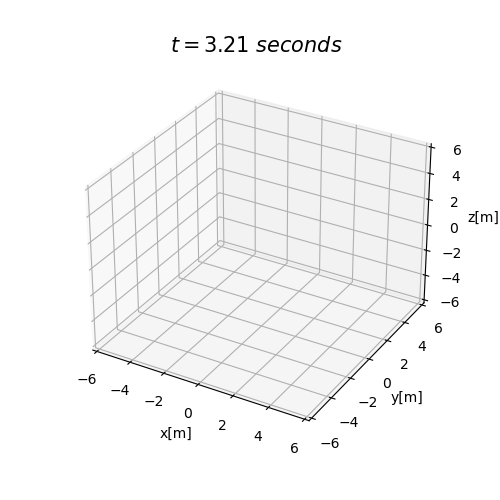

In [51]:
#Para realizar animaciones

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')

#Función de inicio

def init():  #Ajusta la escala de los ejes
    
    ax.set_xlim(-6,6)
    ax.set_ylim(-6,6)
    ax.set_zlim(-6,6)
    
#Función de actualización

def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15) #Ubica el título
    ax.set_xlabel('x[m]')    #Coloca el título a los ejes
    ax.set_ylabel('y[m]')
    ax.set_zlabel('z[m]')
    
    for p in Particles:
        
        x = p.GetRPositionVector()[i,0]
        y = p.GetRPositionVector()[i,1]
        z = p.GetRPositionVector()[i,2]
        
        #circle = plt.Circle((x,y), p.GetR(), color='k', fill = True)
        plot = ax.scatter(x,y,z, color='black')
        
        #plot = ax.arrow(x, y, vx, vy, color='r', head_width=0.5)    #Flecha de velocidad
        
    return plot

Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)